In [1]:
pip install prophet

     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.0 kB ? eta -:--:--
     -------------------------------------- 61.0/61.0 kB 806.3 kB/s eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/162.3 kB ? eta -:--:--
     -------------------------------------- 162.3/162.3 kB 9.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---- ----------------------------------- 1.4/13.3 MB 43.9 MB/s eta 0:00:01
   ---------- ----------------------------- 3.5/13.3 MB 37.9 MB/s eta 0:00:01
   --------------- ------------------------ 5.3/13.3 MB 37.7 MB/s eta 0:00:01
   --------------------- ------------------ 7.2/13.3 MB 38.3 MB/s eta 0:00:01
   --------------------------- ------------ 9.0/13.3 MB 38.6 MB/s eta 0:00:01
   -------

In [44]:
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

In [3]:
# Reemplaza 'ruta_del_archivo' con la ruta correcta de cada archivo CSV
TABLA_ACCIDENTES_VICTIMAS_2016 = 'TABLA_ACCIDENTES_VICTIMAS_2016.xlsx'
TABLA_ACCIDENTES_VICTIMAS_2017 = 'TABLA_ACCIDENTES_VICTIMAS_2017.xlsx'
TABLA_ACCIDENTES_VICTIMAS_2018 = 'TABLA_ACCIDENTES_VICTIMAS_2018.xlsx'
TABLA_ACCIDENTES_VICTIMAS_2019 = 'TABLA_ACCIDENTES_VICTIMAS_2019.xlsx'
TABLA_ACCIDENTES_VICTIMAS_2020 = 'TABLA_ACCIDENTES_VICTIMAS_2020.xlsx'
TABLA_ACCIDENTES_VICTIMAS_2021 = 'TABLA_ACCIDENTES_VICTIMAS_2021.xlsx'

# Cargar bases de datos
db16 = pd.read_excel(TABLA_ACCIDENTES_VICTIMAS_2016)
db17 = pd.read_excel(TABLA_ACCIDENTES_VICTIMAS_2017)
db18 = pd.read_excel(TABLA_ACCIDENTES_VICTIMAS_2018)
db19 = pd.read_excel(TABLA_ACCIDENTES_VICTIMAS_2019)
db20 = pd.read_excel(TABLA_ACCIDENTES_VICTIMAS_2020)
db21 = pd.read_excel(TABLA_ACCIDENTES_VICTIMAS_2021) #este será la bbdd que usaremos como validación del método,
#ya que son los datos más actuales de los que se tiene registro

CREACION DE LA NUEVA BBDD

In [4]:
db16.drop(['SECUENCIAL'], axis = 1, inplace = True)
db17.drop(['SECUENCIAL'], axis = 1, inplace = True)
db18.drop(['SECUENCIAL'], axis = 1, inplace = True)
db19.drop(['SECUENCIAL'], axis = 1, inplace = True)
db20.drop(['SECUENCIAL', 'TOT_VMP_MU24H', 'TOT_VMP_MU30DF'], axis = 1, inplace = True)
db21.drop(['ID_ACCIDENTE', 'TOT_VMP_MU30DF'], axis = 1, inplace = True)

In [5]:
# Concatenar DataFrames verticalmente (uno encima del otro)
db_combinadas = pd.concat([db16, db17, db18, db19, db20], ignore_index=True)

# Mostrar las primeras filas de la nueva base de datos combinada
print(db_combinadas.head())

# Guardar la nueva base de datos combinada en un archivo CSV
db_combinadas.to_csv('TABLA_ACCIDENTES_VICTIMAS_COMBINADAS.csv', index=False)

   ANYO  MES  DIA_SEMANA  HORA  COD_PROVINCIA  COD_MUNICIPIO  ISLA  ZONA  \
0  2016    3           4    16              1         1059.0   NaN     3   
1  2016    3           4    14              1         1059.0   NaN     3   
2  2016    3           4     7              1         1059.0   NaN     3   
3  2016    3           3    18              1         1059.0   NaN     3   
4  2016    3           2    20              1         1059.0   NaN     3   

   ZONA_AGRUPADA        CARRETERA  ...  PRIORI_OTRA  CONDICION_NIVEL_CIRCULA  \
0              2  No inventariada  ...          999                        6   
1              2  No inventariada  ...          999                        6   
2              2  No inventariada  ...          999                        6   
3              2  No inventariada  ...            1                        6   
4              2  No inventariada  ...            1                        6   

   CONDICION_FIRME  CONDICION_ILUMINACION  CONDICION_METEO  CO

In [6]:
# Mostrar las primeras filas
print(db_combinadas.head())

# Obtener información general
print(db_combinadas.info())

# Obtener estadísticas descriptivas
print(db_combinadas.describe())

   ANYO  MES  DIA_SEMANA  HORA  COD_PROVINCIA  COD_MUNICIPIO  ISLA  ZONA  \
0  2016    3           4    16              1         1059.0   NaN     3   
1  2016    3           4    14              1         1059.0   NaN     3   
2  2016    3           4     7              1         1059.0   NaN     3   
3  2016    3           3    18              1         1059.0   NaN     3   
4  2016    3           2    20              1         1059.0   NaN     3   

   ZONA_AGRUPADA        CARRETERA  ...  PRIORI_OTRA  CONDICION_NIVEL_CIRCULA  \
0              2  No inventariada  ...          999                        6   
1              2  No inventariada  ...          999                        6   
2              2  No inventariada  ...          999                        6   
3              2  No inventariada  ...            1                        6   
4              2  No inventariada  ...            1                        6   

   CONDICION_FIRME  CONDICION_ILUMINACION  CONDICION_METEO  CO

Tenemos un total de 573795 datos. Se va a dar una tolerancia del 10% (es decir, puedes tener hasta 516415 datos no nulos) de datos vacíos para simplemente eliminarlos, en caso contrario, se implementarán diferentes estrategias para el llenado de los mismos.
"Sequential" se va a descartar, dado que se trata del índice de la bbdd.
"Isla" se va a descartar como variable porque no hay suficiente información al respecto para determinar adecuadamente con qué llenar adecuadamente los datos vacíos.
Para trabajar con la variable "km" se hará una agrupación por provincias para llenar ese dato con el km donde ocurren más accidentes, es decir, la moda.
"nudo_info" lo mismo que con km.
"carretera_cruce" se va a eliminar, dado que no hay información suficiente y parece ser información muy específica.
"condicion_niebla" y "condicion_viento" se llenará con el promedio por zona y por fecha.


In [7]:
# Identificar columnas con valores nulos y contar el número de nulos por columna
columnas_con_nulos = db_combinadas.columns[db_combinadas.isnull().any()]
num_nulos_por_columna = db_combinadas[columnas_con_nulos].isnull().sum()

# Crear un DataFrame con columnas y el número de nulos por columna
info_nulos = pd.DataFrame({'Columnas con Nulos': columnas_con_nulos, 'Num Nulos': num_nulos_por_columna})

# Mostrar el DataFrame con información sobre los nulos
print("\nInformación sobre Nulos:")
print(info_nulos)


Información sobre Nulos:
                 Columnas con Nulos  Num Nulos
COD_MUNICIPIO         COD_MUNICIPIO       2208
ISLA                           ISLA     451971
KM                               KM     272123
TIPO_VIA                   TIPO_VIA         85
NUDO                           NUDO        290
NUDO_INFO                 NUDO_INFO     293695
CARRETERA_CRUCE     CARRETERA_CRUCE     470674
CONDICION_NIEBLA   CONDICION_NIEBLA     450189
CONDICION_VIENTO   CONDICION_VIENTO     480730


In [8]:
# Lista de columnas a eliminar
columnas_a_eliminar = ['ISLA', 'KM', 'NUDO_INFO', 'CARRETERA_CRUCE']
#para variables como niebla o viento hacer la media y ponerla en los datos vacíos
# Eliminar las columnas especificadas
df = db_combinadas.drop(columnas_a_eliminar, axis=1)

In [9]:
# Identificar columnas con valores nulos y contar el número de nulos por columna
columnas_con_nulos = df.columns[df.isnull().any()]
num_nulos_por_columna = df[columnas_con_nulos].isnull().sum()

# Crear un DataFrame con columnas y el número de nulos por columna
info_nulos = pd.DataFrame({'Columnas con Nulos': columnas_con_nulos, 'Num Nulos': num_nulos_por_columna})

# Mostrar el DataFrame con información sobre los nulos
print("\nInformación sobre Nulos:")
print(info_nulos)


Información sobre Nulos:
                 Columnas con Nulos  Num Nulos
COD_MUNICIPIO         COD_MUNICIPIO       2208
TIPO_VIA                   TIPO_VIA         85
NUDO                           NUDO        290
CONDICION_NIEBLA   CONDICION_NIEBLA     450189
CONDICION_VIENTO   CONDICION_VIENTO     480730


No se ha eliminado condicion_niebla y condicion_viento porque son variables que, aunque haya muchos datos nulos, pueden aportar información valiosa para nuestros resultados, dado que son condiciones meteorológicas que pueden afectar gravemente a un accidente de tráfico.

In [10]:
df['CONDICION_VIENTO'].describe()

count    3203.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: CONDICION_VIENTO, dtype: float64

  Vamos a suponer que 0 hace referencia a cuando no hay viento, mientras que 1 es cuando hace viento. En todos los casos de accidentes registrados, se da la condición 1, es decir, en el lugar del accidente había mucho viento y los datos nulos serán llenados con 0. Lo IDEAL EN ESTOS CASOS ES TRABAJAR JUNTO CON LOS DATA ENFENEER O INGENIEROS de datos para conocer como dse creó esa variable en la bbdd.

In [11]:
df['CONDICION_VIENTO'].fillna(0, inplace = True)

C:\Users\---\AppData\Local\Temp\ipykernel_11876\1088846255.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CONDICION_VIENTO'].fillna(0, inplace = True)


In [12]:
df['CONDICION_NIEBLA'].describe()

count    33744.000000
mean         1.019974
std          0.139913
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: CONDICION_NIEBLA, dtype: float64

0
674


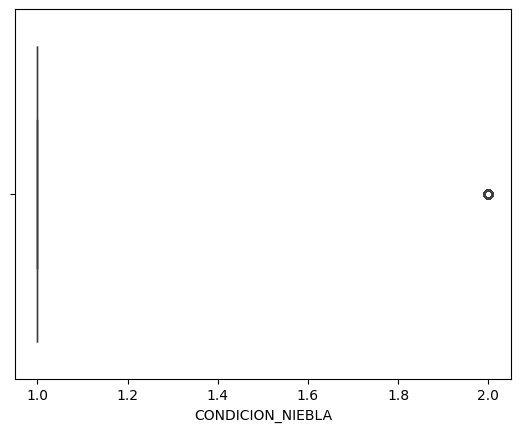

In [13]:
sns.boxplot(data = df, x = 'CONDICION_NIEBLA')
print(len(df[df['CONDICION_NIEBLA'] < 1]))
print(len(df[df['CONDICION_NIEBLA'] > 1]))

Vamos a tener en cuenta lo mismo que con el viento, es decir, que había niebla cuando se dieron los accidentes.

In [14]:
df['CONDICION_NIEBLA'].fillna(0, inplace = True)

C:\Users\---\AppData\Local\Temp\ipykernel_11876\3816337909.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CONDICION_NIEBLA'].fillna(0, inplace = True)


In [15]:
df.dropna(inplace = True)

In [16]:
df.describe()

,ANYO,MES,DIA_SEMANA,HORA,COD_PROVINCIA,COD_MUNICIPIO,ZONA,ZONA_AGRUPADA,SENTIDO_1F,TITULARIDAD_VIA,...,PRIORI_OTRA,CONDICION_NIVEL_CIRCULA,CONDICION_FIRME,CONDICION_ILUMINACION,CONDICION_METEO,CONDICION_NIEBLA,CONDICION_VIENTO,VISIB_RESTRINGIDA_POR,ACERA,TRAZADO_PLANTA
count,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,...,481350.000000,481350.000000,481350.00000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000
mean,2017.890252,6.570699,3.865518,13.887047,23.226955,20283.337787,2.267095,1.638832,3.304907,3.378577,...,651.045794,159.620738,1.58964,2.102715,66.289187,0.071503,0.006654,119.004789,910.932448,618.727369
std,1.361707,3.425031,1.935025,5.274615,14.190114,15246.607092,0.962904,0.480339,1.139958,1.082246,...,475.896472,362.529116,5.96771,13.947410,245.934881,0.263042,0.081302,313.591756,281.177691,483.607326
min,2016.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2017.000000,4.000000,2.000000,10.000000,8.000000,8019.000000,1.000000,1.000000,2.000000,3.000000,...,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,1.000000,998.000000,2.000000
50%,2018.000000,7.000000,4.000000,14.000000,27.000000,18122.000000,3.000000,2.000000,4.000000,4.000000,...,999.000000,3.000000,1.00000,1.000000,1.000000,0.000000,0.000000,1.000000,998.000000,998.000000
75%,2019.000000,10.000000,5.000000,18.000000,33.000000,30030.000000,3.000000,2.000000,4.000000,4.000000,...,999.000000,6.000000,1.00000,3.000000,1.000000,0.000000,0.000000,18.000000,998.000000,998.000000
max,2020.000000,12.000000,7.000000,23.000000,52.000000,52001.000000,4.000000,2.000000,4.000000,5.000000,...,999.000000,999.000000,999.00000,999.000000,999.000000,2.000000,1.000000,999.000000,999.000000,998.000000


In [17]:
df.reset_index(drop = True)

,ANYO,MES,DIA_SEMANA,HORA,COD_PROVINCIA,COD_MUNICIPIO,ZONA,ZONA_AGRUPADA,CARRETERA,SENTIDO_1F,...,PRIORI_OTRA,CONDICION_NIVEL_CIRCULA,CONDICION_FIRME,CONDICION_ILUMINACION,CONDICION_METEO,CONDICION_NIEBLA,CONDICION_VIENTO,VISIB_RESTRINGIDA_POR,ACERA,TRAZADO_PLANTA
0,2016,3,4,16,1,1059.0,3,2,No inventariada,4,...,999,6,9,1,7,0.0,0.0,18,998,998
1,2016,3,4,14,1,1059.0,3,2,No inventariada,4,...,999,6,9,1,7,0.0,0.0,18,999,998
2,2016,3,4,7,1,1059.0,3,2,No inventariada,4,...,999,6,9,4,7,0.0,0.0,18,998,998
3,2016,3,3,18,1,1059.0,3,2,No inventariada,4,...,1,6,9,1,7,0.0,0.0,18,998,998
4,2016,3,2,20,1,1059.0,3,2,No inventariada,4,...,1,6,9,4,7,0.0,0.0,18,998,998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481345,2020,12,1,15,52,52001.0,3,2,No inventariada,4,...,999,1,1,1,1,0.0,0.0,1,998,998
481346,2020,12,4,9,52,52001.0,3,2,No inventariada,4,...,0,1,1,1,1,0.0,0.0,1,4,998
481347,2020,12,5,17,52,52001.0,3,2,No inventariada,4,...,999,2,1,2,1,0.0,0.0,1,4,998
481348,2020,12,4,21,52,52001.0,3,2,No inventariada,4,...,999,3,1,4,1,0.0,0.0,1,4,998


De acuerdo con el objetivo de este trabajo, en las bbdd trabajadas anteriormente se encuentran varias variables que podemos usar como target u variable objetivo. Haciendo un análisis del significado de cada una de ellas, la que mejor se amolda es 'TOTAL_VICTIMAS_24H', la cual nos dice el número de heridos hospitalizados, heridos no hospitalizados y victimas mortales durante el accidente.

ANÁLISIS DE VARIABLES

Para poder trabajar todas las variables dentro de un modelo, necesitamos que estas estén categorizadas. 
En particular, durante este trabajo se les van a dar un orden de acuerdo al análisis de bivariados para de esta
 manera mejorar la correlación de la variable de interes con la objetivo.

In [19]:
len(list(df['CARRETERA'].unique())) #como son 10738 valores únicos para la variable carretera,
#vamos a aprovechar el label encoder de sklearn

10738

In [20]:
enc_car = LabelEncoder()
df['CARRETERA'] = enc_car.fit_transform(df['CARRETERA'])
df.describe()

,ANYO,MES,DIA_SEMANA,HORA,COD_PROVINCIA,COD_MUNICIPIO,ZONA,ZONA_AGRUPADA,CARRETERA,SENTIDO_1F,...,PRIORI_OTRA,CONDICION_NIVEL_CIRCULA,CONDICION_FIRME,CONDICION_ILUMINACION,CONDICION_METEO,CONDICION_NIEBLA,CONDICION_VIENTO,VISIB_RESTRINGIDA_POR,ACERA,TRAZADO_PLANTA
count,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,...,481350.000000,481350.000000,481350.00000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000
mean,2017.890252,6.570699,3.865518,13.887047,23.226955,20283.337787,2.267095,1.638832,7139.661554,3.304907,...,651.045794,159.620738,1.58964,2.102715,66.289187,0.071503,0.006654,119.004789,910.932448,618.727369
std,1.361707,3.425031,1.935025,5.274615,14.190114,15246.607092,0.962904,0.480339,2860.231924,1.139958,...,475.896472,362.529116,5.96771,13.947410,245.934881,0.263042,0.081302,313.591756,281.177691,483.607326
min,2016.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2017.000000,4.000000,2.000000,10.000000,8.000000,8019.000000,1.000000,1.000000,7786.000000,2.000000,...,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,1.000000,998.000000,2.000000
50%,2018.000000,7.000000,4.000000,14.000000,27.000000,18122.000000,3.000000,2.000000,8617.000000,4.000000,...,999.000000,3.000000,1.00000,1.000000,1.000000,0.000000,0.000000,1.000000,998.000000,998.000000
75%,2019.000000,10.000000,5.000000,18.000000,33.000000,30030.000000,3.000000,2.000000,8617.000000,4.000000,...,999.000000,6.000000,1.00000,3.000000,1.000000,0.000000,0.000000,18.000000,998.000000,998.000000
max,2020.000000,12.000000,7.000000,23.000000,52.000000,52001.000000,4.000000,2.000000,10737.000000,4.000000,...,999.000000,999.000000,999.00000,999.000000,999.000000,2.000000,1.000000,999.000000,999.000000,998.000000


MATRIZ DE CORRELACION

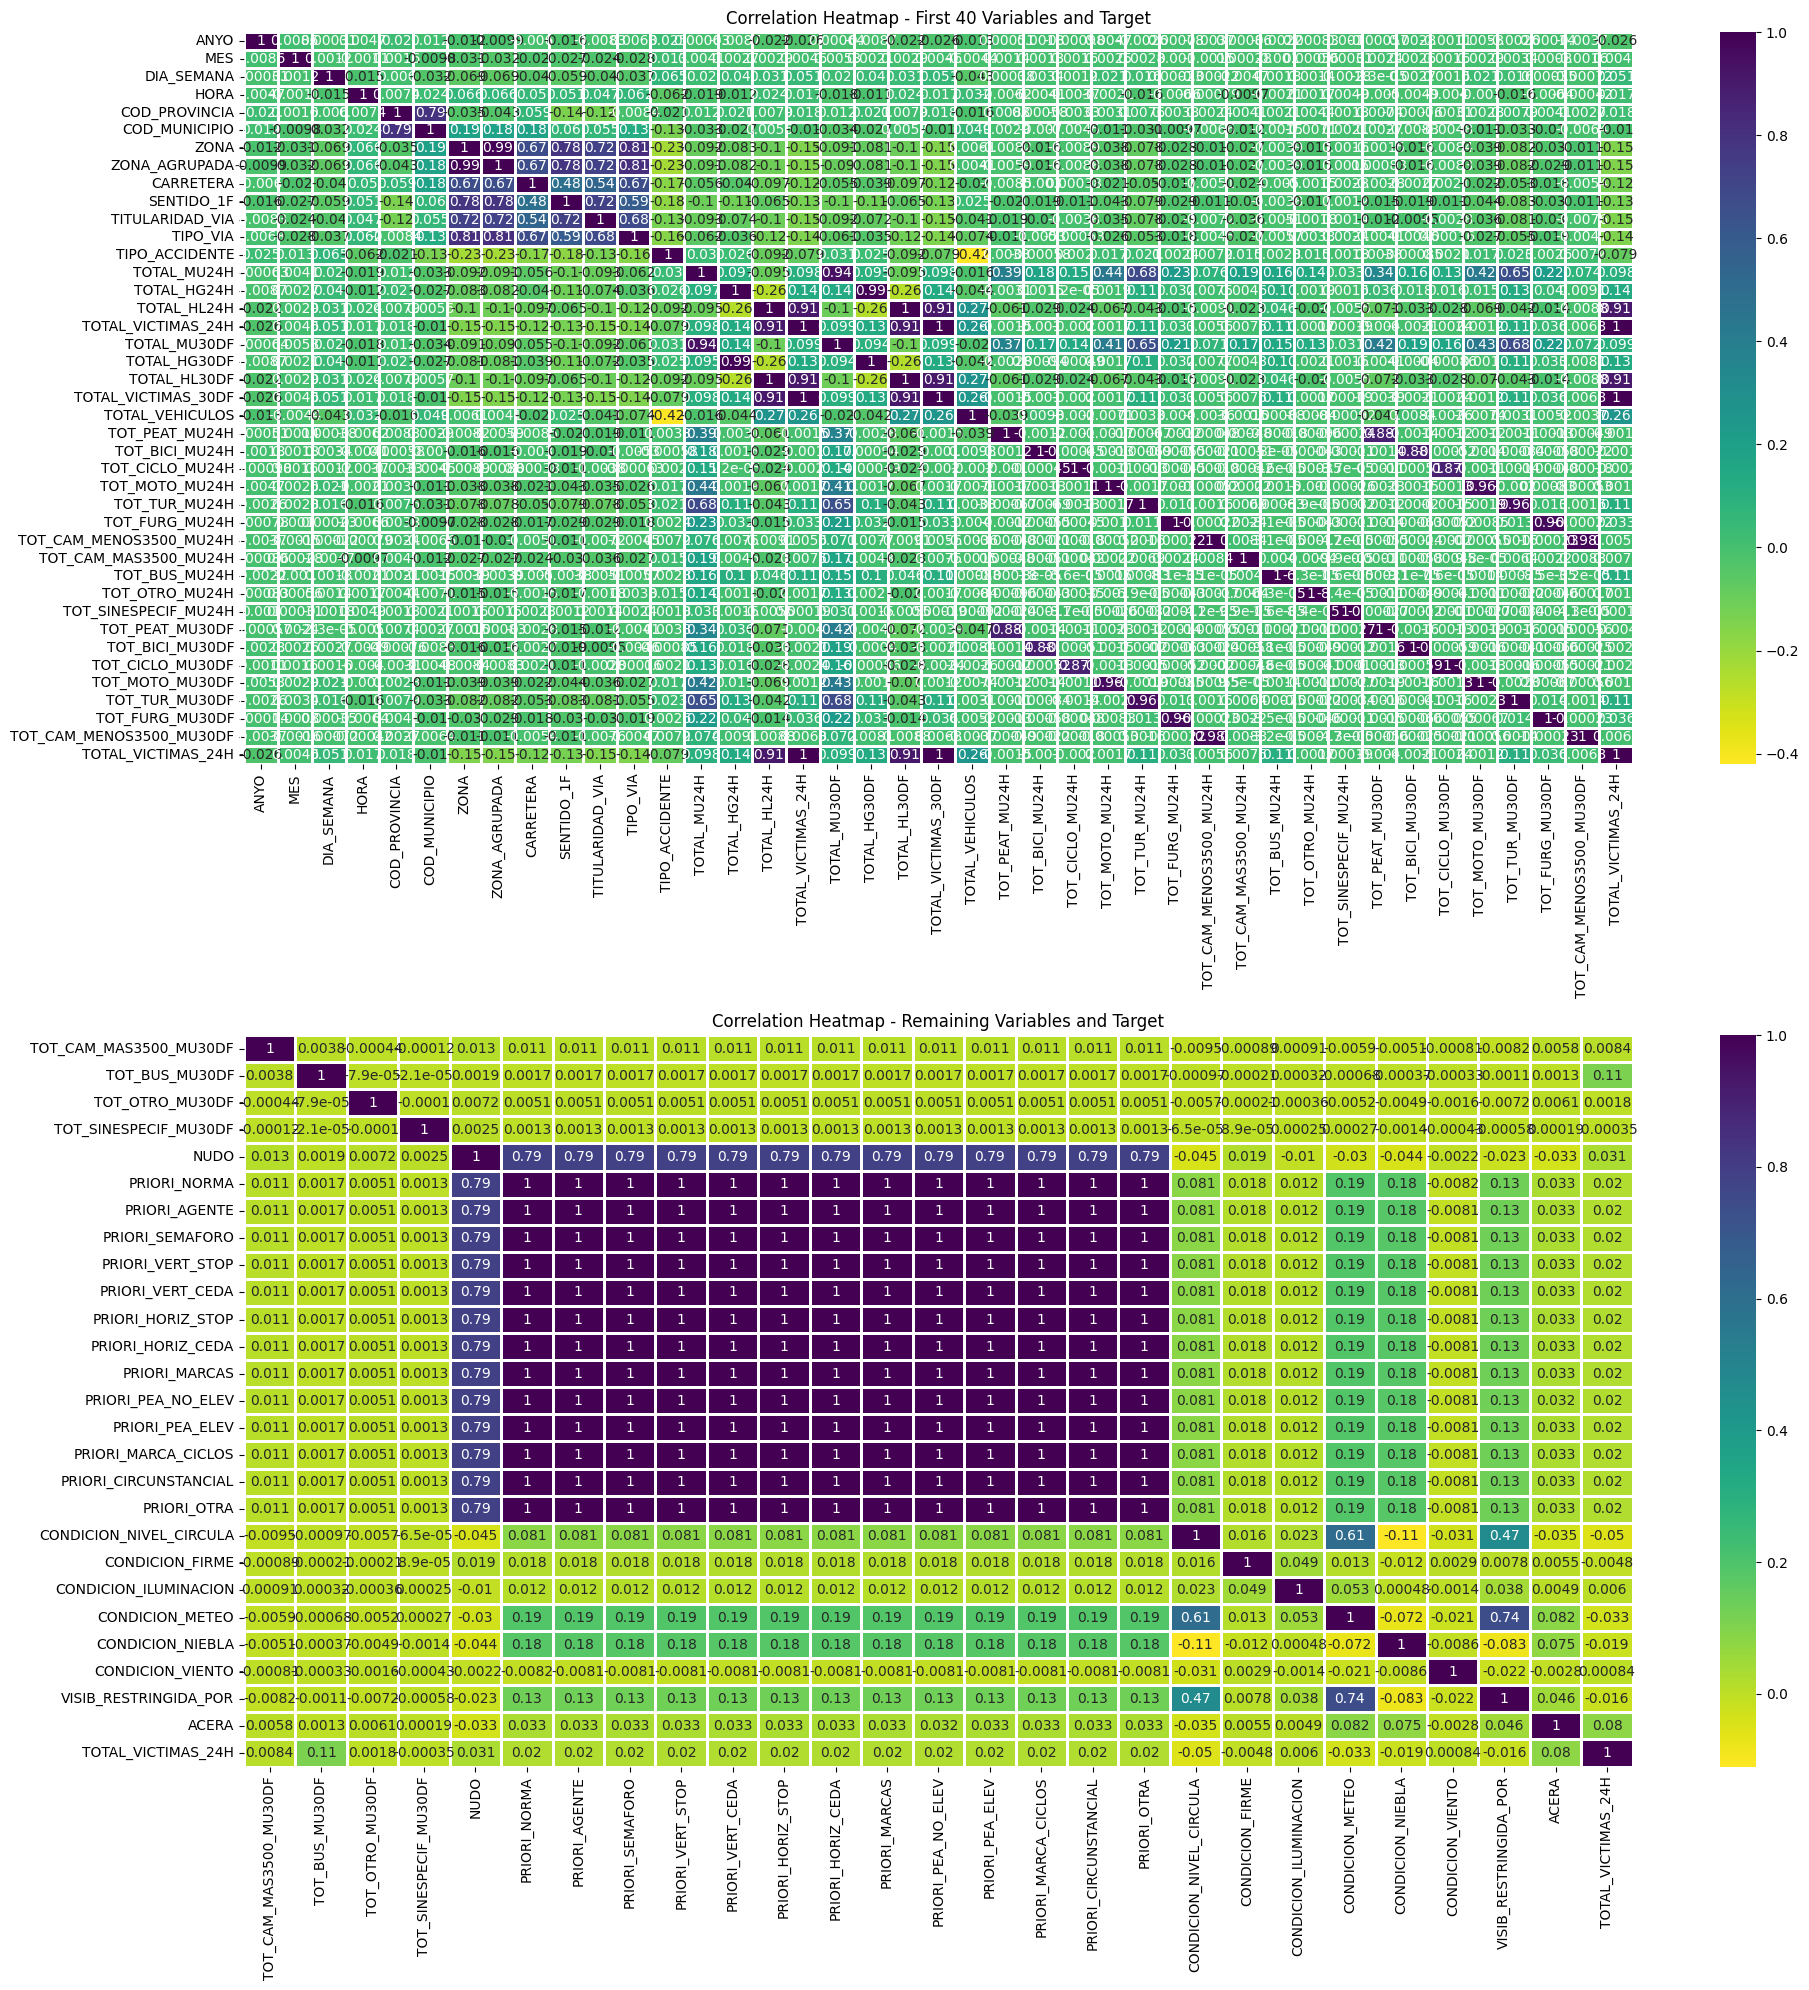

In [21]:
num_vars_in_first_heatmap = 40

first_x_vars_with_target = df.iloc[:, :num_vars_in_first_heatmap]
remaining_vars = df.iloc[:, num_vars_in_first_heatmap:-1]

remaining_vars_with_target = pd.concat([remaining_vars, df['TOTAL_VICTIMAS_24H']], axis=1)

fig, axes = plt.subplots(2, 1, figsize=(20, 20))

first_x_vars_with_target_with_label = pd.concat([first_x_vars_with_target, df['TOTAL_VICTIMAS_24H']], axis=1)

sns.heatmap(first_x_vars_with_target_with_label.corr(), annot=True, cmap='viridis_r', linecolor='white', linewidths=0.8, ax=axes[0])
axes[0].set_title(f'Correlation Heatmap - First {num_vars_in_first_heatmap} Variables and Target')

sns.heatmap(remaining_vars_with_target.corr(), annot=True, cmap='viridis_r', linecolor='white', linewidths=0.8, ax=axes[1])
axes[1].set_title('Correlation Heatmap - Remaining Variables and Target')

plt.tight_layout()

plt.show()

In [22]:
#vamos a eliminar todas las variables tipo priori, dado que, como podemos observar en la matriz de correlación, están muy correlacionadas entre sí.
#Además, analizando su significado dentro de la bbdd, se puede ver que no tiene relevancia para nuestro modelo predictivo, ya que solo considera
#el responsable del accidente de acuerdo a diversos factores.
# Lista de columnas a eliminar
columnas_a_eliminar = ['PRIORI_NORMA', 'PRIORI_AGENTE', 'PRIORI_SEMAFORO', 'PRIORI_VERT_STOP', 'PRIORI_VERT_CEDA', 'PRIORI_HORIZ_STOP', 'PRIORI_HORIZ_CEDA', 'PRIORI_MARCAS', 'PRIORI_PEA_NO_ELEV', 'PRIORI_PEA_ELEV', 'PRIORI_MARCA_CICLOS', 'PRIORI_CIRCUNSTANCIAL', 'PRIORI_OTRA']
#para variables como niebla o viento hacer la media y ponerla en los datos vacíos
# Eliminar las columnas especificadas
df = df.drop(columnas_a_eliminar, axis=1)

In [23]:
#vamos a eliminar TOTAL_HL24H y TOTAL_HL30DF ya que tienen una correlación de 0,91, es decir, demasiado alta con la variable objetivo
# Lista de columnas a eliminar
columnas_a_eliminar = ['TOTAL_HL24H', 'TOTAL_HL30DF']
#para variables como niebla o viento hacer la media y ponerla en los datos vacíos
# Eliminar las columnas especificadas
df = df.drop(columnas_a_eliminar, axis=1)

In [24]:
features = list(df.columns)
features.remove('TOTAL_VICTIMAS_24H')
print(features)

['ANYO', 'MES', 'DIA_SEMANA', 'HORA', 'COD_PROVINCIA', 'COD_MUNICIPIO', 'ZONA', 'ZONA_AGRUPADA', 'CARRETERA', 'SENTIDO_1F', 'TITULARIDAD_VIA', 'TIPO_VIA', 'TIPO_ACCIDENTE', 'TOTAL_MU24H', 'TOTAL_HG24H', 'TOTAL_MU30DF', 'TOTAL_HG30DF', 'TOTAL_VICTIMAS_30DF', 'TOTAL_VEHICULOS', 'TOT_PEAT_MU24H', 'TOT_BICI_MU24H', 'TOT_CICLO_MU24H', 'TOT_MOTO_MU24H', 'TOT_TUR_MU24H', 'TOT_FURG_MU24H', 'TOT_CAM_MENOS3500_MU24H', 'TOT_CAM_MAS3500_MU24H', 'TOT_BUS_MU24H', 'TOT_OTRO_MU24H', 'TOT_SINESPECIF_MU24H', 'TOT_PEAT_MU30DF', 'TOT_BICI_MU30DF', 'TOT_CICLO_MU30DF', 'TOT_MOTO_MU30DF', 'TOT_TUR_MU30DF', 'TOT_FURG_MU30DF', 'TOT_CAM_MENOS3500_MU30DF', 'TOT_CAM_MAS3500_MU30DF', 'TOT_BUS_MU30DF', 'TOT_OTRO_MU30DF', 'TOT_SINESPECIF_MU30DF', 'NUDO', 'CONDICION_NIVEL_CIRCULA', 'CONDICION_FIRME', 'CONDICION_ILUMINACION', 'CONDICION_METEO', 'CONDICION_NIEBLA', 'CONDICION_VIENTO', 'VISIB_RESTRINGIDA_POR', 'ACERA', 'TRAZADO_PLANTA']


C:\Users\---\AppData\Local\Temp\ipykernel_11876\1994944297.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])  #using seaborn to plot
C:\Users\---\AppData\Local\Temp\ipykernel_11876\1994944297.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])  #using seaborn to plot
C:\Users

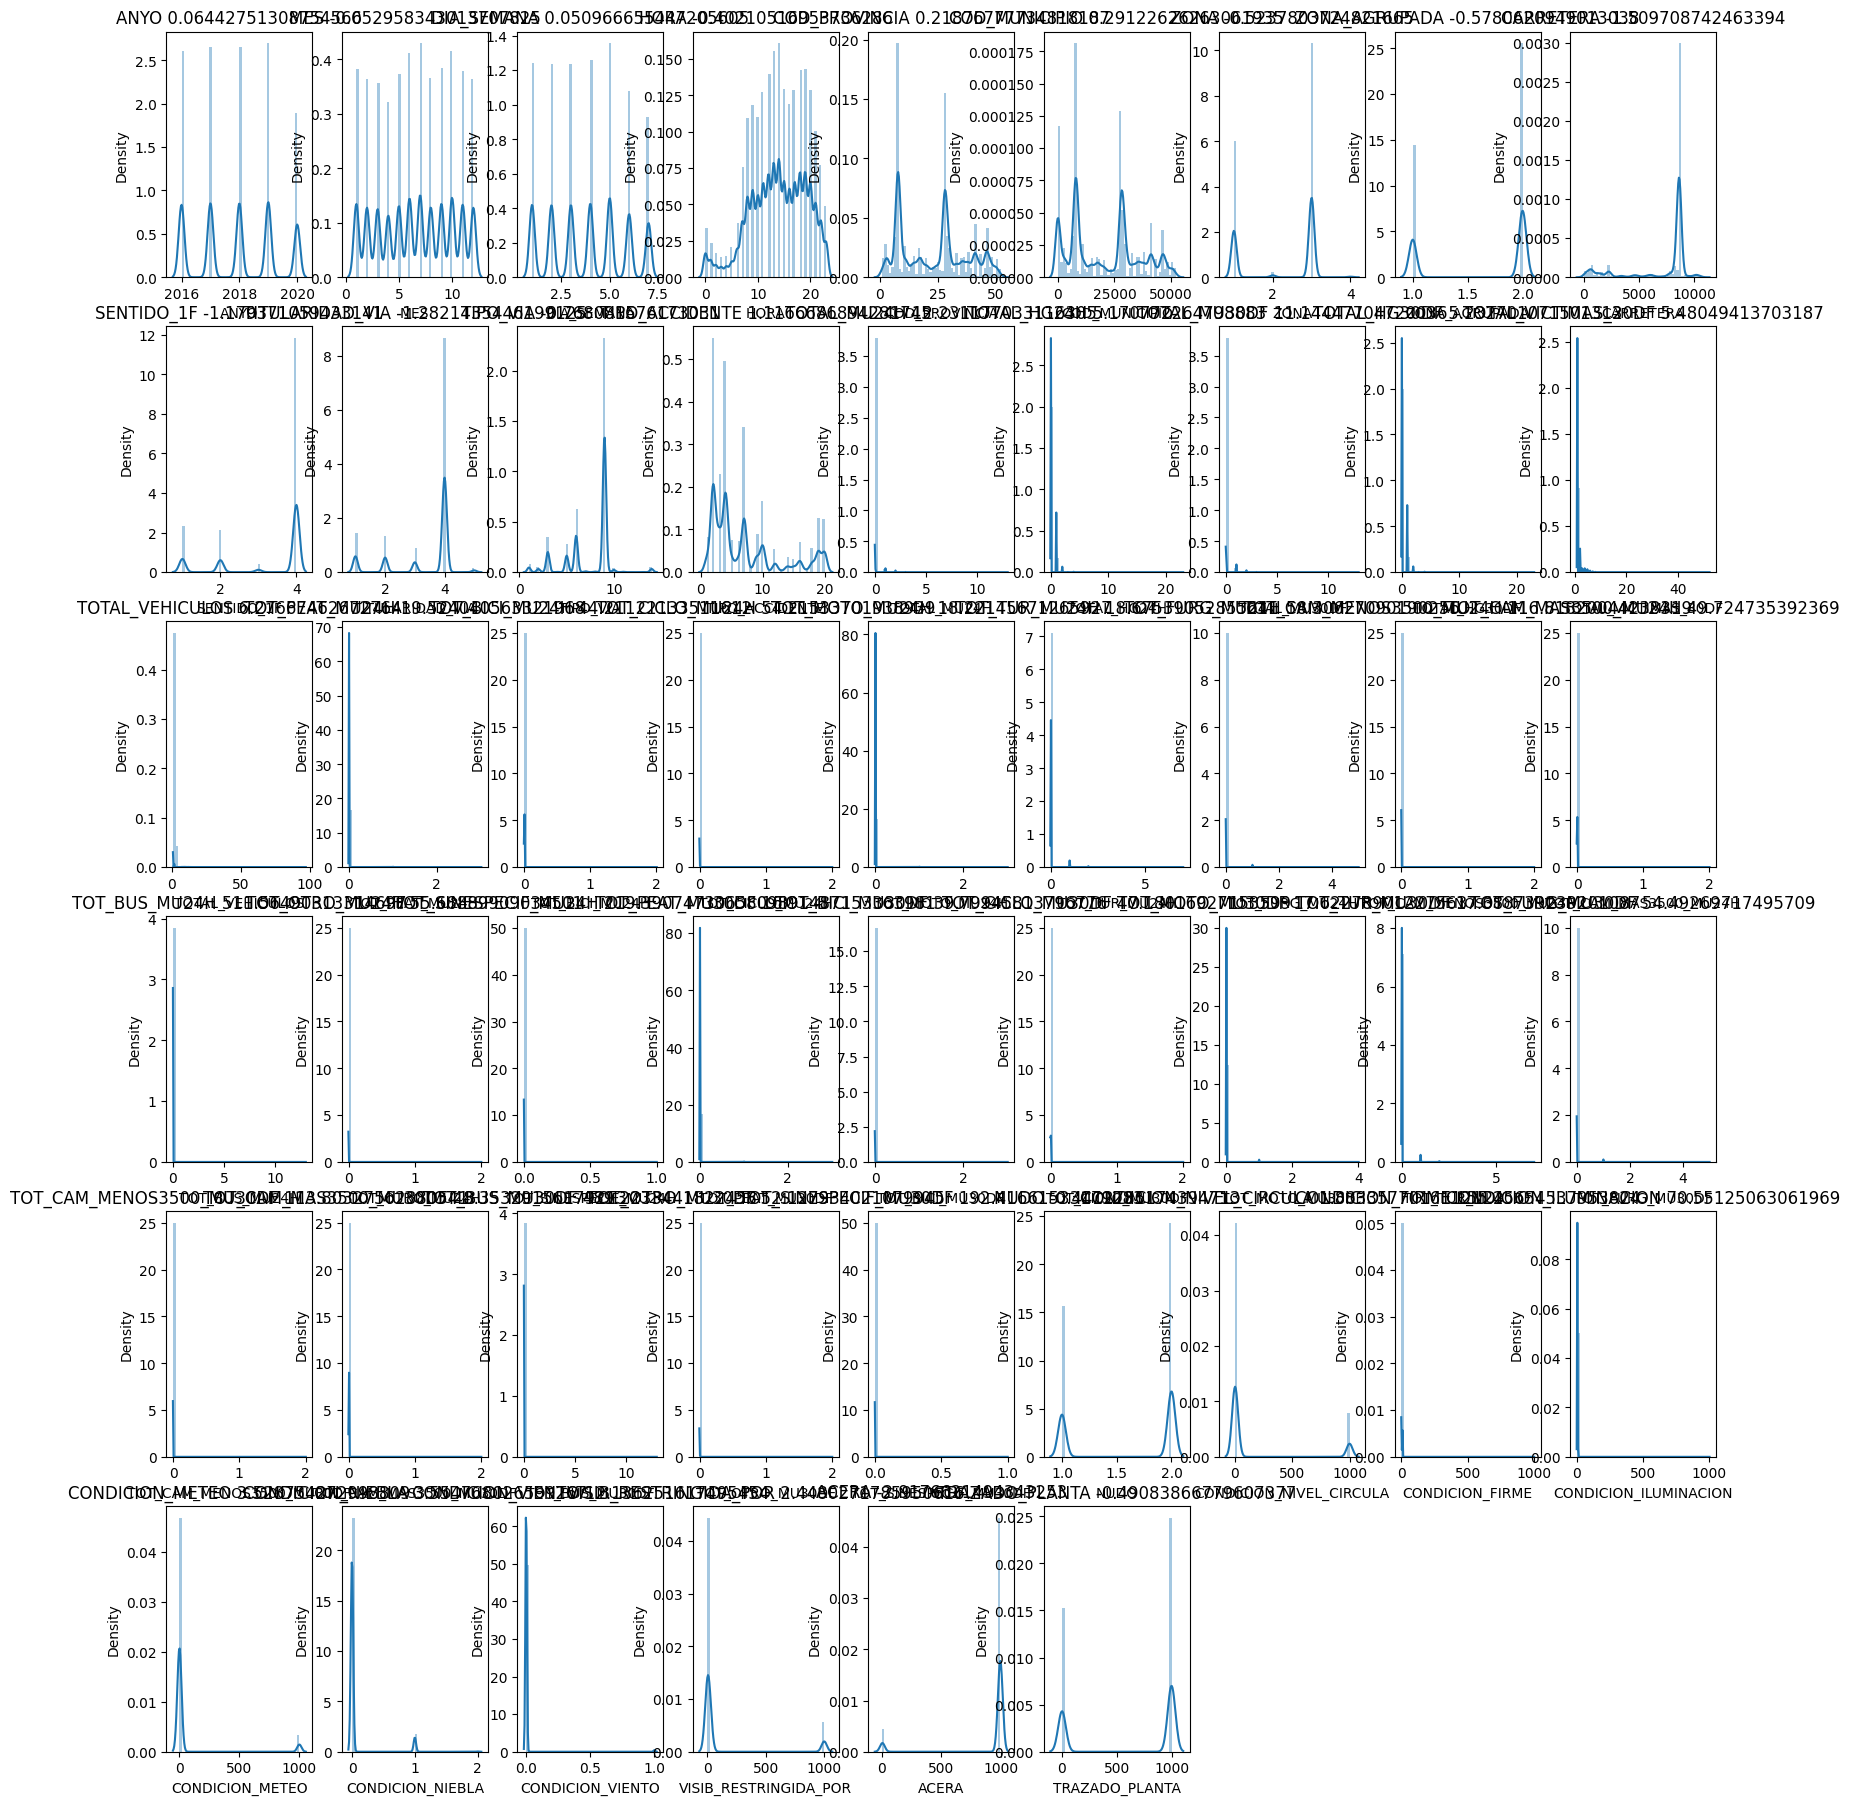

In [25]:
# Plotting the distribution of the variables (skewness) of all the columns
k=0
plt.figure(figsize=(20,30))

for col in features :
    k=k+1
    plt.subplot(8, 9,k)
    sns.distplot(df[col])  #using seaborn to plot
    plt.title(col+' '+str(df[col].skew()))

In [26]:
#matriz de correlación
#gráficas de distribucion de variables y de sesgo
#modelo con prophet
#INVESIGAR SOBRE PROPHET PARA METERLO EN EL MARCO TEORICO

In [27]:
df.describe()

,ANYO,MES,DIA_SEMANA,HORA,COD_PROVINCIA,COD_MUNICIPIO,ZONA,ZONA_AGRUPADA,CARRETERA,SENTIDO_1F,...,NUDO,CONDICION_NIVEL_CIRCULA,CONDICION_FIRME,CONDICION_ILUMINACION,CONDICION_METEO,CONDICION_NIEBLA,CONDICION_VIENTO,VISIB_RESTRINGIDA_POR,ACERA,TRAZADO_PLANTA
count,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,...,481350.000000,481350.000000,481350.00000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000,481350.000000
mean,2017.890252,6.570699,3.865518,13.887047,23.226955,20283.337787,2.267095,1.638832,7139.661554,3.304907,...,1.607728,159.620738,1.58964,2.102715,66.289187,0.071503,0.006654,119.004789,910.932448,618.727369
std,1.361707,3.425031,1.935025,5.274615,14.190114,15246.607092,0.962904,0.480339,2860.231924,1.139958,...,0.488257,362.529116,5.96771,13.947410,245.934881,0.263042,0.081302,313.591756,281.177691,483.607326
min,2016.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2017.000000,4.000000,2.000000,10.000000,8.000000,8019.000000,1.000000,1.000000,7786.000000,2.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,1.000000,998.000000,2.000000
50%,2018.000000,7.000000,4.000000,14.000000,27.000000,18122.000000,3.000000,2.000000,8617.000000,4.000000,...,2.000000,3.000000,1.00000,1.000000,1.000000,0.000000,0.000000,1.000000,998.000000,998.000000
75%,2019.000000,10.000000,5.000000,18.000000,33.000000,30030.000000,3.000000,2.000000,8617.000000,4.000000,...,2.000000,6.000000,1.00000,3.000000,1.000000,0.000000,0.000000,18.000000,998.000000,998.000000
max,2020.000000,12.000000,7.000000,23.000000,52.000000,52001.000000,4.000000,2.000000,10737.000000,4.000000,...,2.000000,999.000000,999.00000,999.000000,999.000000,2.000000,1.000000,999.000000,999.000000,998.000000


ANALISIS DE LA VARIABLE TEMPORAL

De acuerdo con la base de datos, la parte temporal se divide en año, mes y día de la semana. El último, toma valores del 1 al 7, es decir, de lunes a domingo. Sin embargo, no se especifica de qué semana se trata. Por tanto, el análisis que se puede hacer a partir de esta bbdd es mensual.

In [28]:
df_agrupado = df.groupby(by = ['ANYO', 'MES', 'DIA_SEMANA']).mean()
df_agrupado

HORA  COD_PROVINCIA  COD_MUNICIPIO      ZONA  \
ANYO MES DIA_SEMANA                                                      
2016 1   1           14.365118      23.550937   21276.199674  2.395273   
         2           13.942830      23.529522   21705.121837  2.427366   
         3           14.162939      22.584665   20816.627263  2.425985   
         4           14.214735      23.787960   21858.890386  2.420485   
         5           14.125639      23.911614   22237.270270  2.419284   
...                        ...            ...            ...       ...   
2020 12  3           14.503667      24.211084   21932.557457  2.276284   
         4           14.419409      23.007595   20573.669198  2.283544   
         5           14.394352      24.674781   21935.960078  2.253165   
         6           15.443196      24.960050   21827.288390  2.220974   
         7           14.495868      25.059504   21154.133884  2.226446   

                     ZONA_AGRUPADA    CARRETERA  SENTIDO_1F  TITULARIDAD_VIA  \
ANYO MES DIA_SEMANA                                                            
2016 1   1                1.702526  7315.370823    3.431133         3.459658   
         2                1.717901  7447.284911    3.441425         3.479850   
         3                1.716720  7444.284345    3.484558         3.481363   
         4                1.712489  7383.487871    3.427673         3.427673   
         5                1.714390  7429.540541    3.417823         3.475530   
...                            ...          ...         ...              ...   
2020 12  3                1.643847  7174.532192    3.300733         3.374898   
         4                1.645570  7161.232911    3.333333         3.383966   
         5                1.633885  7023.205453    3.249270         3.355404   
         6                1.611735  7006.556804    3.132335         3.315855   
         7                1.621488  7260.322314    3.165289         3.386777   

                     TIPO_VIA  TIPO_ACCIDENTE  ...      NUDO  \
ANYO MES DIA_SEMANA                            ...             
2016 1   1           7.739201        6.354523  ...  1.587612   
         2           7.795689        6.308341  ...  1.623243   
         3           7.849840        6.091587  ...  1.586794   
         4           7.685535        6.584007  ...  1.561545   
         5           7.738495        6.744339  ...  1.606282   
...                       ...             ...  ...       ...   
2020 12  3           7.550122        6.700896  ...  1.594132   
         4           7.491139        6.931646  ...  1.609283   
         5           7.465433        7.333009  ...  1.613437   
         6           7.560549        7.845194  ...  1.612984   
         7           7.753719        7.720661  ...  1.581818   

                     CONDICION_NIVEL_CIRCULA  CONDICION_FIRME  \
ANYO MES DIA_SEMANA                                             
2016 1   1                        185.118174         2.128769   
         2                        185.295220         1.921275   
         3                        191.052183         1.811502   
         4                        225.182390         2.044025   
         5                        215.035062         2.162893   
...                                      ...              ...   
2020 12  3                        123.105134         1.502037   
         4                         75.324895         1.514768   
         5                         86.309640         1.884129   
         6                         89.513109         1.680400   
         7                         96.190083         1.497521   

                     CONDICION_ILUMINACION  CONDICION_METEO  CONDICION_NIEBLA  \
ANYO MES DIA_SEMANA                                                             
2016 1   1                        2.281989       100.315403          0.007335   
         2                        2.044986        99.951265          0.029991   
         3         

Al agrupar simplemente por año, mes y dia_semana, perdemos información acerca de las condiciones particulares de cada municipio. El objetivo de este proyecto es mandar la información más fidedigna posible a usuarios, servicios de seguridad y personal sanitario, por lo que decir que todas las condicionesde distintos municipios del país es en promedio la misma, implica una pérdida de información. Por como está construída la bbdd no se tiene la seguridad de cómo se condificaron los códigos de municipio, por lo que se descartará la opción de analizar los accidentes ocurridos en los municipios y se tomará mejor por provincia, asumiento que el código de provincia hace referencia al código postal.  
Hacer una lista de provincias con su respectivo código postal:  
01  Álava  
02	Albacete  
03	Alicante  
04	Almería  
05	Ávila  
06	Badajoz  
07	Baleares  
08	Barcelona  
09	Burgos  
10	Cáceres  
11	Cádiz  
12	Castellón  
13	Ciudad Real  
14	Córdoba  
15	La Coruña  
16	Cuenca  
17	Gerona  
18	Granada  
19	Guadalajara  
20	Guipúzcoa  
21	Huelva  
22	Huesca  
23	Jaén  
24	León  
25	Lérida  
26	La Rioja  
27	Lugo  
28	Madrid  
29	Málaga   
30	Murcia  
31	Navarra  
32	Orense  
33	Asturias  
34	Palencia  
35	Las Palmas  
36	Pontevedra  
37	Salamanca  
38	Santa Cruz de Tenerife  
39	Cantabria  
40	Segovia  
41	Sevilla  
42	Soria  
43	Tarragona  
44	Teruel  
45	Toledo  
46	Valencia  
47	Valladolid  
48	Vizcaya  
49	Zamora  
50	Zaragoza  
51	Ceuta  
52	Melilla  

### AVILA

In [33]:
avila = df[df['COD_PROVINCIA'] == 1]
avila

,ANYO,MES,DIA_SEMANA,HORA,COD_PROVINCIA,COD_MUNICIPIO,ZONA,ZONA_AGRUPADA,CARRETERA,SENTIDO_1F,...,NUDO,CONDICION_NIVEL_CIRCULA,CONDICION_FIRME,CONDICION_ILUMINACION,CONDICION_METEO,CONDICION_NIEBLA,CONDICION_VIENTO,VISIB_RESTRINGIDA_POR,ACERA,TRAZADO_PLANTA
0,2016,3,4,16,1,1059.0,3,2,8617,4,...,2.0,6,9,1,7,0.0,0.0,18,998,998
1,2016,3,4,14,1,1059.0,3,2,8617,4,...,2.0,6,9,1,7,0.0,0.0,18,999,998
2,2016,3,4,7,1,1059.0,3,2,8617,4,...,2.0,6,9,4,7,0.0,0.0,18,998,998
3,2016,3,3,18,1,1059.0,3,2,8617,4,...,1.0,6,9,1,7,0.0,0.0,18,998,998
4,2016,3,2,20,1,1059.0,3,2,8617,4,...,1.0,6,9,4,7,0.0,0.0,18,998,998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411818,2020,1,3,15,1,1059.0,3,2,8617,4,...,1.0,1,1,1,1,0.0,0.0,18,998,998
411819,2020,1,3,18,1,1059.0,3,2,8617,4,...,1.0,1,1,4,1,0.0,0.0,18,998,998
411820,2020,1,3,20,1,1059.0,3,2,8617,4,...,1.0,1,1,4,1,0.0,0.0,18,998,998
411821,2020,3,7,9,1,1059.0,3,2,8617,4,...,2.0,1,1,1,1,0.0,0.0,18,998,998


In [34]:
avila_group = avila.groupby(by = ['ANYO', 'MES', 'DIA_SEMANA']).mean()
avila_group

HORA  COD_PROVINCIA  COD_MUNICIPIO      ZONA  \
ANYO MES DIA_SEMANA                                                      
2016 1   1           16.600000            1.0    1059.000000  3.000000   
         2           14.166667            1.0     882.500000  3.000000   
         3           16.750000            1.0    1059.000000  3.000000   
         4           16.000000            1.0     882.500000  3.000000   
         5           13.222222            1.0    1059.000000  3.000000   
...                        ...            ...            ...       ...   
2020 12  3           14.333333            1.0     588.333333  2.111111   
         4           12.714286            1.0     981.714286  2.714286   
         5           17.400000            1.0     635.400000  2.200000   
         6           17.000000            1.0     736.700000  2.200000   
         7           13.000000            1.0     604.000000  1.857143   

                     ZONA_AGRUPADA    CARRETERA  SENTIDO_1F  TITULARIDAD_VIA  \
ANYO MES DIA_SEMANA                                                            
2016 1   1                2.000000  8617.000000    4.000000         4.000000   
         2                2.000000  8617.000000    4.000000         4.000000   
         3                2.000000  8617.000000    4.000000         4.000000   
         4                2.000000  8617.000000    4.000000         4.000000   
         5                2.000000  8617.000000    4.000000         4.000000   
...                            ...          ...         ...              ...   
2020 12  3                1.555556  4988.111111    3.000000         3.555556   
         4                1.857143  7451.285714    3.642857         3.928571   
         5                1.600000  5348.000000    3.100000         3.600000   
         6                1.600000  5386.400000    3.000000         3.600000   
         7                1.428571  3819.714286    2.428571         3.571429   

                     TIPO_VIA  TIPO_ACCIDENTE  ...      NUDO  \
ANYO MES DIA_SEMANA                            ...             
2016 1   1           9.000000        5.000000  ...  1.800000   
         2           9.833333        6.166667  ...  1.833333   
         3           9.000000        5.750000  ...  1.750000   
         4           9.833333        9.333333  ...  1.166667   
         5           9.000000        6.666667  ...  1.666667   
...                       ...             ...  ...       ...   
2020 12  3           7.111111        6.333333  ...  1.777778   
         4           8.500000        7.071429  ...  1.714286   
         5           7.000000        8.500000  ...  1.900000   
         6           7.500000        7.300000  ...  1.800000   
         7           6.428571       14.714286  ...  1.857143   

                     CONDICION_NIVEL_CIRCULA  CONDICION_FIRME  \
ANYO MES DIA_SEMANA                                             
2016 1   1                          6.000000         9.000000   
         2                          5.166667         8.000000   
         3                          6.000000         9.000000   
         4                          5.166667         7.666667   
         5                          6.000000         9.000000   
...                                      ...              ...   
2020 12  3                          1.111111         2.555556   
         4                          1.000000         1.857143   
         5                          1.000000         1.800000   
         6                          1.200000         2.600000   
         7                          1.000000         2.857143   

                     CONDICION_ILUMINACION  CONDICION_METEO  CONDICION_NIEBLA  \
ANYO MES DIA_SEMANA                                                             
2016 1   1                        2.800000         7.000000               0.0   
         2                        2.166667         7.000000               0.0   
         3         

Se puede comprobar que por ejemplo los lunes de enero de 2016, hay que tener cuidado sobre las cuatro de la tarde. En enero de 2016 se debería tomar precaución a las cuatro de la tarde.

Ahora vamos a analizar la bbdd buscando estacionalidad anual, mensual, semanal o de otro tipo. Para ello, primero creamos una columna que se llame fecha, en la que habra el mes y el año correspondientes.

In [38]:
diccionario = { clave: avila_group.index.get_level_values(i) for i, clave in enumerate(("year", "month", "day"))}
avila_group.index = pd.to_datetime(diccionario)

IndexError: Too many levels: Index has only 1 level, not 2

In [40]:
avila_group = avila_group.reset_index()
avila_group

,index,HORA,COD_PROVINCIA,COD_MUNICIPIO,ZONA,ZONA_AGRUPADA,CARRETERA,SENTIDO_1F,TITULARIDAD_VIA,TIPO_VIA,...,NUDO,CONDICION_NIVEL_CIRCULA,CONDICION_FIRME,CONDICION_ILUMINACION,CONDICION_METEO,CONDICION_NIEBLA,CONDICION_VIENTO,VISIB_RESTRINGIDA_POR,ACERA,TRAZADO_PLANTA
0,2016-01-01,16.600000,1.0,1059.000000,3.000000,2.000000,8617.000000,4.000000,4.000000,9.000000,...,1.800000,6.000000,9.000000,2.800000,7.000000,0.0,0.0,18.000000,998.400000,998.000000
1,2016-01-02,14.166667,1.0,882.500000,3.000000,2.000000,8617.000000,4.000000,4.000000,9.833333,...,1.833333,5.166667,8.000000,2.166667,7.000000,0.0,0.0,15.166667,832.500000,998.000000
2,2016-01-03,16.750000,1.0,1059.000000,3.000000,2.000000,8617.000000,4.000000,4.000000,9.000000,...,1.750000,6.000000,9.000000,2.500000,7.000000,0.0,0.0,18.000000,998.750000,998.000000
3,2016-01-04,16.000000,1.0,882.500000,3.000000,2.000000,8617.000000,4.000000,4.000000,9.833333,...,1.166667,5.166667,7.666667,2.000000,7.000000,0.0,0.0,15.333333,998.166667,998.000000
4,2016-01-05,13.222222,1.0,1059.000000,3.000000,2.000000,8617.000000,4.000000,4.000000,9.000000,...,1.666667,6.000000,9.000000,2.333333,7.000000,0.0,0.0,18.000000,998.333333,998.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,2020-12-03,14.333333,1.0,588.333333,2.111111,1.555556,4988.111111,3.000000,3.555556,7.111111,...,1.777778,1.111111,2.555556,2.444444,2.777778,0.0,0.0,10.444444,998.000000,555.333333
413,2020-12-04,12.714286,1.0,981.714286,2.714286,1.857143,7451.285714,3.642857,3.928571,8.500000,...,1.714286,1.000000,1.857143,1.642857,1.785714,0.0,0.0,13.714286,998.214286,855.785714
414,2020-12-05,17.400000,1.0,635.400000,2.200000,1.600000,5348.000000,3.100000,3.600000,7.000000,...,1.900000,1.000000,1.800000,2.400000,1.300000,0.0,0.0,11.200000,998.100000,599.400000
415,2020-12-06,17.000000,1.0,736.700000,2.200000,1.600000,5386.400000,3.000000,3.600000,7.500000,...,1.800000,1.200000,2.600000,3.000000,2.300000,0.0,0.0,9.900000,998.200000,599.500000


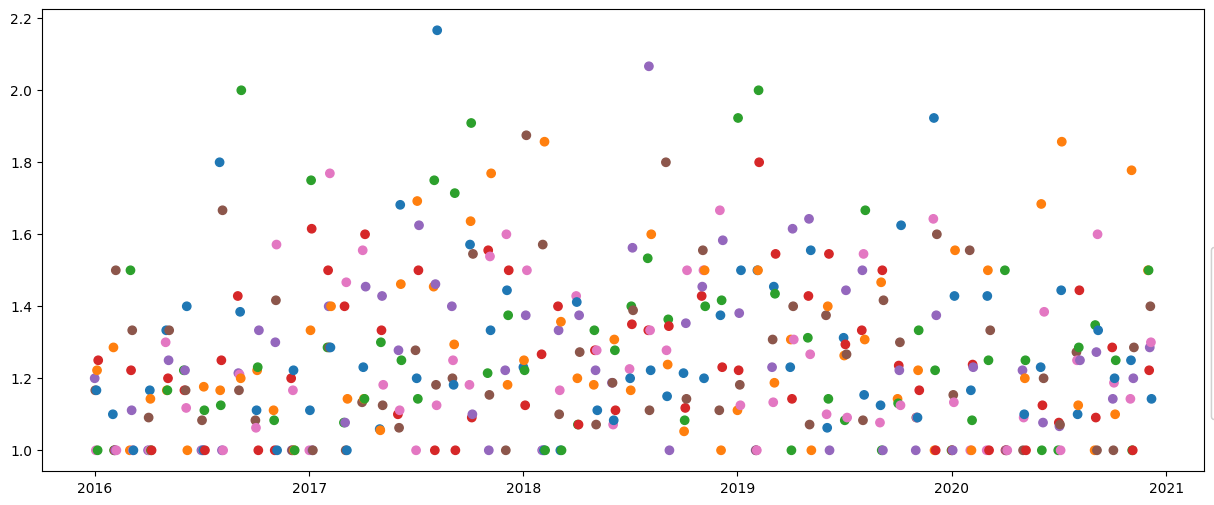

In [48]:
dayofweek_colors = {0: 'tab:blue', 1: 'tab:orange',
                    2: 'tab:green', 3: 'tab:red', 
                    4: 'tab:purple', 5: 'tab:brown', 
                    6: 'tab:pink'}
fig, ax = plt.subplots(figsize = (15, 6))
ax.scatter(avila_group['index'], avila_group['TOTAL_VICTIMAS_24H'], c = avila_group['index'].dt.day_of_week.map(dayofweek_colors))
handles = [mpatches.Patch(color=v, label=k) for v, k in zip(dayofweek_colors.values(), dayofweek_colors.keys())]
legend = ax.legend(handles=handles, bbox_to_anchor=(1, 0.5),
                   title="Día de la semana")
ax.add_artist(legend)
plt.show()

Podemos ver que en la gráfica no se da ningún tipo de estacionalidad a lo largo de los años, ya que no se encuentra ningún patrón en cada mes. Los valores del numero de victimas en accidentes fluctuan demasiado.